In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd gdrive/Shared drives/group5/numpy

/content/gdrive/Shared drives/group5/numpy


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torchvision.models as models
import matplotlib.pyplot as plt

In [4]:
with np.load('./new_total_train_X.npz') as data:
    X_train_np = data['arr_0']

with np.load('./new_total_train_Y.npz') as data:
    Y_train_np = data['arr_0']


X_train = torch.from_numpy(X_train_np).float()
Y_train = torch.as_tensor(Y_train_np).long()

print(X_train.shape)
print(Y_train.shape)

train = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train, batch_size=64, shuffle=True)

torch.Size([16500, 3, 64, 64])
torch.Size([16500])


In [5]:
with np.load('./new_val_X.npz') as data:
    X_val = data['arr_0']

with np.load('./new_val_Y.npz') as data:
    Y_val = data['arr_0']


X_val = torch.as_tensor(X_val).float()
Y_val = torch.as_tensor(Y_val).long()

print(X_val.shape)
print(Y_val.shape)

val = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val, batch_size=64, shuffle=True)

torch.Size([1650, 3, 64, 64])
torch.Size([1650])


In [6]:
with np.load('./new_test_X.npz') as data:
    X_test = data['arr_0']

with np.load('./new_test_Y.npz') as data:
    Y_test = data['arr_0']

X_test = torch.as_tensor(X_test).float()
Y_test = torch.as_tensor(Y_test).long()

print(X_test.shape)
print(Y_test.shape)

test = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test, batch_size=64, shuffle=True)


torch.Size([1644, 3, 64, 64])
torch.Size([1644])


In [0]:
#gpu할당.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
#mini batch size
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

258
26
26


In [0]:
# model is wide_resnet50_2 #
num_classes= 11
net= models.wide_resnet50_2(pretrained= True).cuda()
net.fc=nn.Linear(2048,num_classes,bias=True)
net= net.cuda()

In [0]:
# hyperparameter zone #
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3 #1e-3이 loss 가장 높은 accuracy 69%, 1e-5가 가장 낮은 accuracy 23%
momentum = 0.5
weight_decay=1e-4    #1e-4일 때 69%, 1e-5일 때 68%,  0일 때 68%. 
optimizer = optim.SGD(net.parameters(), lr=learning_rate, 
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

In [12]:
#train test
train_loss_list = []

for epoch in range(5):
    train_loss = 0.0
    for i, data in enumerate(train_loader,0):
      X_train, Y_train = data
      X_train, Y_train = X_train.cuda(), Y_train.cuda()
         
      # grad init
      optimizer.zero_grad()
      # forward propagation
      model_output = net(X_train)
      # calculate loss
      loss = criterion(model_output, Y_train)
      #l2 regularization
      reg_lambda = 0.001
      l2_reg = 0.
      for param in net.parameters():
        l2_reg += param.norm(2)  
      loss = loss + reg_lambda * l2_reg             
      # back propagation 
      loss.backward()
      # weight update
      optimizer.step()
        
      # tainn_loss summary
      train_loss += loss.item()
      # del (memory issue)
      del loss
      del model_output

    # print loss, val_loss
    j = len(train_loader)
    print('[%d] loss: %.5f' %(epoch+1, train_loss/(j+1)))
    train_loss_list.append(train_loss/(j+1))

[1] loss: 2.32805
[2] loss: 1.89593
[3] loss: 1.60755
[4] loss: 1.38774
[5] loss: 1.22904


In [20]:
#validation test
val_loss_list = []

with torch.no_grad(): 
  val_loss = 0.0
  for i, val in enumerate(val_loader,0):
    X_val, Y_val = val
    X_val, Y_val = X_val.to(device), Y_val.to(device)
    val_output = net(X_val)
    v_loss = criterion(val_output, Y_val)
    #l2 regularization
    reg_lambda = 0.001
    l2_reg = 0.
    for param in net.parameters():
      l2_reg += param.norm(2)  
    v_loss = v_loss + reg_lambda * l2_reg         
    val_loss += v_loss  
    del v_loss
    del val_output
      
i = len(val_loader)
print('validation loss: %.5f' %(val_loss /(i+1)))   

a = val_loss /(i+1)
for i in range(5):
  val_loss_list.append(a)

validation loss: 1.93640


In [0]:
#accuracy
classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

A = np.zeros((11,11))

class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

X_test, Y_test = X_test.to(device), Y_test.to(device)

with torch.no_grad():
    for k, test in enumerate(test_loader,0):
      X_test, Y_test = test
      X_test, Y_test = X_test.to(device), Y_test.to(device) 
      outputs = net(X_test)
      _, predicted = torch.max(outputs, 1) # prediction
      c = (predicted == Y_test).squeeze()
      for i in range(len(predicted)):
        A[predicted[i]][Y_test[i]] += 1

In [24]:
total = np.zeros((11))
correct = np.zeros((11))
correct_total = 0

prob_class = np.zeros((11,11))

for i in range(11):
  for j in range(11):
   total[j] += A[i][j]
   class_total += total[j]

for i in range(11):
  correct[i] += A[i][i]
  correct_total += correct[i]

for i in range(11):
  for j in range(11):
    prob_class[i][j] = A[i][j] / total[j]

for i in range(11):
  print('Accuracy of %5s : %2d %%' % (classes[i], 100 * correct[i] / total[i]))

print('Total Accuracy: %2d %%' % (correct_total*100 / 1644))

Accuracy of Bread : 33 %
Accuracy of Dairy product : 59 %
Accuracy of Dessert : 34 %
Accuracy of   Egg : 74 %
Accuracy of Fried food : 70 %
Accuracy of  Meat : 65 %
Accuracy of Noodles-Pasta : 78 %
Accuracy of  Rice : 85 %
Accuracy of Seafood : 69 %
Accuracy of  Soup : 81 %
Accuracy of Vegetable-Fruit : 81 %
Total Accuracy: 66 %


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


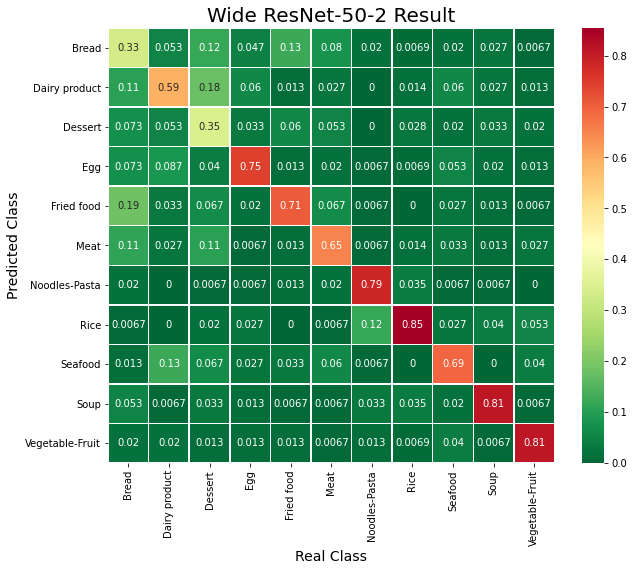

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit')

plt.figure(figsize = (10,8))
sns.heatmap(prob_class, xticklabels=classes, yticklabels=classes, annot=True, cmap='RdYlGn_r', linewidths=.5)
plt.title('Wide ResNet-50-2 Result', fontsize=20)
plt.xlabel('Real Class', fontsize=14)
plt.ylabel('Predicted Class', fontsize=14)

plt.show()